Resources used 
- https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html


In [11]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [12]:
def show_images(img1, img2 = None,bw = False, ):
    if img2 is None:
        fig = plt.figure(figsize=(13,13))
        ax = fig.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(img1,cmap='Greys_r' if bw else None)
        plt.show()
    else :
        plt.figure(figsize=(13,10))
        plt.subplot(2,1,1)
        plt.imshow(img1)
        plt.title('Left Camera Image')
        plt.subplot(2,1,2)
        plt.imshow(img2)
        plt.title('Right Camera Image')
        plt.show()


def drawlines(img1,img2,lines,pts1,pts2):
    r,c,_ = img1.shape
    # img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    # img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


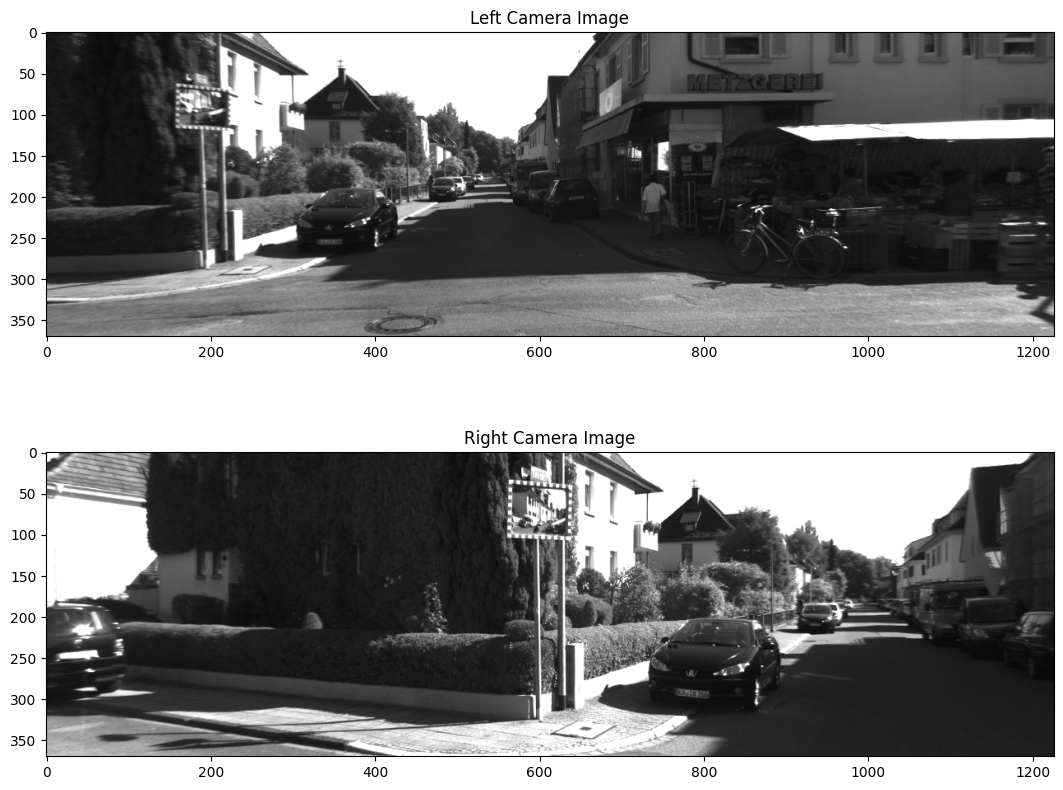

In [13]:

# Load the fundamental matrix
F=[[3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
   [-5.83765868e-06,  1.36498636e-06, 2.67566877e-04],
   [1.45892349e-03, -4.37648316e-03,  1.00000000e+00]]
F = np.array(F)
# Load the images
img1 = cv2.imread('/home/iiticos/Desktop/College/8th sem/CV/Assignment/Images/Question 2 and 3 Images/000000.png')
img2 = cv2.imread('/home/iiticos/Desktop/College/8th sem/CV/Assignment/Images/Question 2 and 3 Images/000023.png')
show_images(img1 = img1,img2 = img2)

In [14]:
def partA(img1,img2,F):
    grayL = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(grayL,None)
    kp2, des2 = sift.detectAndCompute(grayR,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    good_matches = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good_matches.append(m)

    pts1 = np.int32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,2)
    pts2 = np.int32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,2)
    print(f"Shpae of Points1, Points2: {pts1.shape,pts2.shape}")
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    show_images(img3,img5)
    show_images(img4,img6)
    return lines1, lines2, pts1, pts2

Shpae of Points1, Points2: ((311, 2), (311, 2))


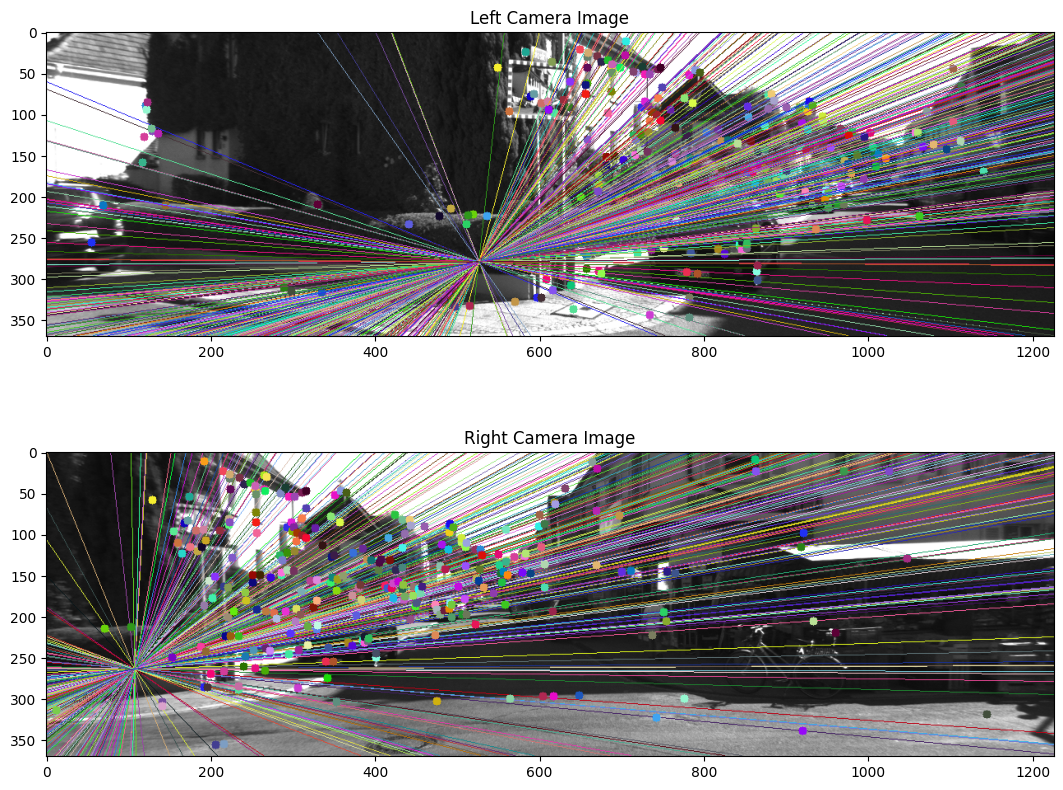

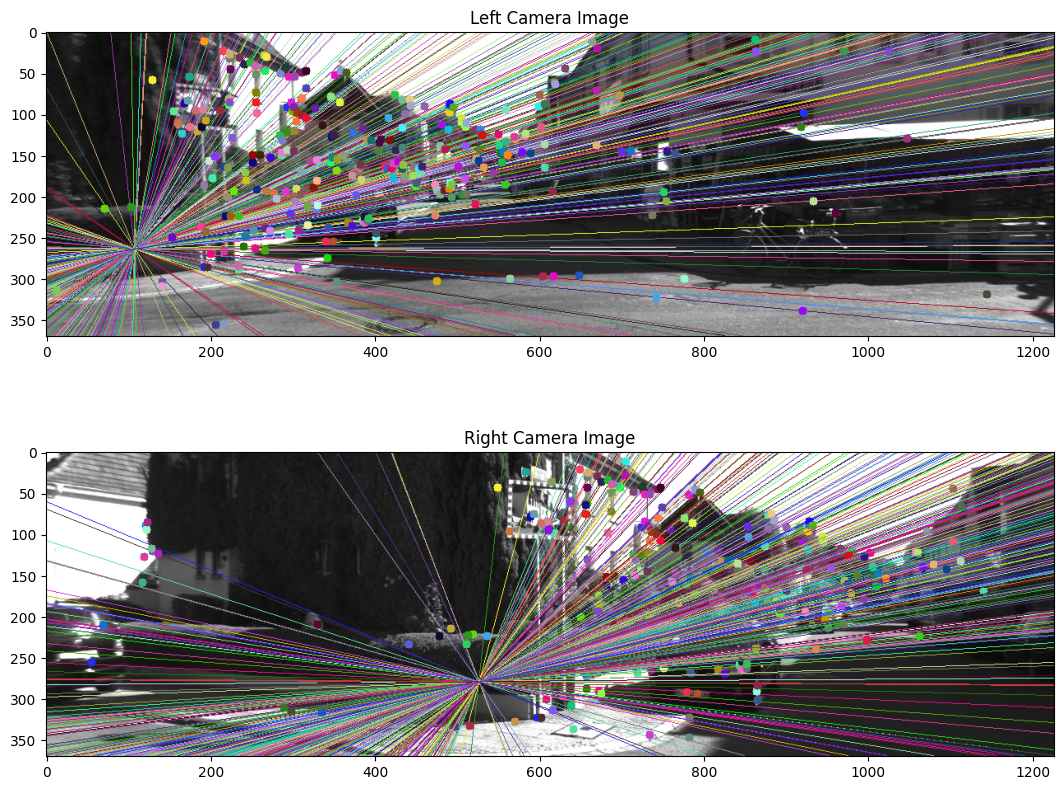

length of lines1, lines2, pts1, pts2: (311, 311, 311, 311)


In [26]:
image1 = img1.copy()
image2 = img2.copy()
lines1,lines2,pts1,pts2 =partA(image1,image2,F)
print(f"length of lines1, lines2, pts1, pts2: {len(lines1),len(lines2),len(pts1),len(pts2)}")

# Part B

In [16]:
def findEpipolarLine(point, F, side="left"):
    # Convert point to homogeneous coordinates
    # point_homog = np.append(point, [1])
    point_homog = point
    if side == "left":
        return point_homog @ F
    else:
        return (F @ point_homog.T).T

In [28]:
def find_corresponding_pixels(image1, image2, F, epipolar_line1, epipolar_line2, num_points=10, search_range=5):

  # Corresponding points lists
  corresps_1to2 = []
  corresps_2to1 = []

  # Loop for each point on first epipolar line
  for i in range(num_points):
    # p1 = (epipolar_line1[0] * i + epipolar_line1[1], epipolar_line1[2] * i + epipolar_line1[3])
    slope, y_intercept = epipolar_line1[0], epipolar_line1[1]
    p1 = (i, slope * i + y_intercept)


    # Reproject p1 to second image using F
    p2_line = cv2.computeCorrespondEpilines(np.array([p1]), 1, F)[0].ravel()

    # Search for correspondence on second epipolar line
    best_p2 = None
    min_error = float('inf')
    for j in range(max(0, int(p2_line[1] - search_range)), min(image2.shape[0], int(p2_line[1] + search_range))):
      p2 = (p2_line[0], j)
      # Calculate reprojection error (Sampson distance can be used here)
      error = compute_reprojection_error(F, p1, p2)
      if error < min_error:
        min_error = error
        best_p2 = p2

    corresps_1to2.append((p1, best_p2))

  # Repeat for second epipolar line
  for i in range(num_points):
    # p2 = (epipolar_line2[0] * i + epipolar_line2[1], epipolar_line2[2] * i + epipolar_line2[3])
    slope, y_intercept = epipolar_line2[0], epipolar_line2[1]
    p1 = (i, slope * i + y_intercept)
    p1_line = cv2.computeCorrespondEpilines(np.array([p2]), 1, F.T)[0].ravel()

    best_p1 = None
    min_error = float('inf')
    for j in range(max(0, int(p1_line[1] - search_range)), min(image1.shape[0], int(p1_line[1] + search_range))):
      p1 = (p1_line[0], j)
      error = compute_reprojection_error(F, p2, p1)
      if error < min_error:
        min_error = error
        best_p1 = p1

    corresps_2to1.append((p2, best_p1))

  return corresps_1to2, corresps_2to1

def compute_reprojection_error(F, p1, p2):
  p1_hat = cv2.convertPointsToHomogeneous(np.array([p1])).squeeze()
  line2 = F.dot(p1_hat)
  line2 /= line2[2]  # Normalize

  # Distance between point and epipolar line
  error = np.linalg.norm(np.cross(line2, np.array([p2[0], p2[1], 1])))
  return error


epipolar_line1 = lines1[310]
epipolar_line2 = lines2[310]
corresps_1to2, corresps_2to1 = find_corresponding_pixels(img1, img2, F, epipolar_line1, epipolar_line2)

# Print corresponding points
print("Corresponding pixels (image1 to image2):")
for p1, p2 in corresps_1to2:
  print(f"  - Point in 1: ({p1[0]},{p1[1]}) -> Point in 2: ({p2[0]},{p2[1]})")

print("Corresponding pixels (image2 to image1):")
for p2, p1 in corresps_2to1:
  print(f"  - Point in 2: ({p2[0]},{p2[1]}) -> Point in 1: ({p1[0]},{p1[1]})")


Corresponding pixels (image1 to image2):
  - Point in 1: (0,-0.9864687919616699) -> Point in 2: (-0.9916645545838648,0)
  - Point in 1: (1,-1.1504178792238235) -> Point in 2: (-0.9920423122718891,0)
  - Point in 1: (2,-1.3143669664859772) -> Point in 2: (-0.992411295697386,0)
  - Point in 1: (3,-1.4783160537481308) -> Point in 2: (-0.9927714988794357,0)
  - Point in 1: (4,-1.6422651410102844) -> Point in 2: (-0.993122916534404,0)
  - Point in 1: (5,-1.806214228272438) -> Point in 2: (-0.9934655440760773,0)
  - Point in 1: (6,-1.9701633155345917) -> Point in 2: (-0.9937993776156504,0)
  - Point in 1: (7,-2.1341124027967453) -> Point in 2: (-0.9941244139615578,0)
  - Point in 1: (8,-2.298061490058899) -> Point in 2: (-0.9944406506191522,0)
  - Point in 1: (9,-2.4620105773210526) -> Point in 2: (-0.9947480857902313,0)
Corresponding pixels (image2 to image1):
  - Point in 2: (-0.9947480857902313,4) -> Point in 1: (0.31148083477408195,0)
  - Point in 2: (-0.9947480857902313,4) -> Point in 1

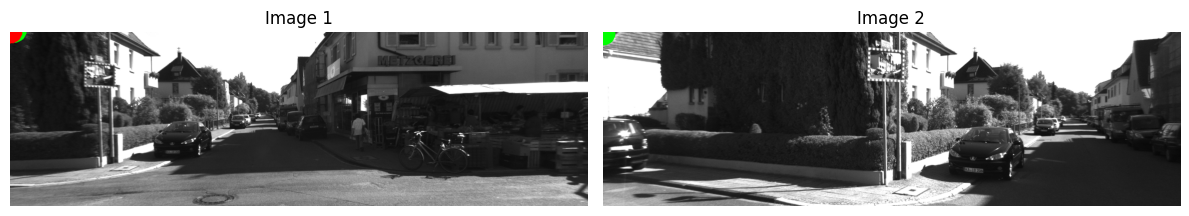

In [30]:
corresps_1to2, corres_2to1 = find_corresponding_pixels(img1, img2, F, epipolar_line1, epipolar_line2)
img1_copy = img1.copy()
img2_copy = img2.copy()

# Draw corresponding points with circles
circle_radius = 1  # Adjust circle radius as needed
circle_thickness = 50# Fill circles

for p1, p2 in corresps_1to2:
  cv2.circle(img1_copy, (int(p1[0]), int(p1[1])), circle_radius, (0, 255, 0), circle_thickness)  # Green circle for points in image 1
  if p2 is not None:  # Check if correspondence is found
    cv2.circle(img2_copy, (int(p2[0]), int(p2[1])), circle_radius, (0, 0, 255), circle_thickness)  # Red circle for corresponding points in image 2

for p2, p1 in corres_2to1:
  cv2.circle(img2_copy, (int(p2[0]), int(p2[1])), circle_radius, (0, 255, 0), circle_thickness)  # Green circle for points in image 2
  if p1 is not None:  # Check if correspondence is found
    cv2.circle(img1_copy, (int(p1[0]), int(p1[1])), circle_radius, (0, 0, 255), circle_thickness)  # Red circle for corresponding points in image 1

# Display images with corresponding points
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img1_copy[..., ::-1])  
plt.title("Image 1")
plt.axis('off')

plt.subplot(122)
plt.imshow(img2_copy[..., ::-1])
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()
